In [1]:
import numpy as np
from glob import glob

In [2]:
import librosa.display
import IPython

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses

2022-11-30 14:39:46.081155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data_dir = '/Users/charlieelwess/Dropbox/LE_WAGON/FINAL_PROJECT/First_Kick_Spectrograms'

In [5]:
audiofiles = glob(data_dir + '/*.npy')

In [6]:
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

In [7]:
data = load_data(data_dir)

In [8]:
X_train = data[:2000, :, :]

In [9]:
X_valid = data[2000:2500, :, :]

imports

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [11]:
codings_size = 100

encoder, mean and log_var take in same input from second layer hense not being sequential

In [12]:
inputs = layers.Input(shape=[256,188])
z = layers.Flatten()(inputs)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

2022-11-30 14:40:00.157660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


decoder

In [13]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(256 * 188, activation='sigmoid')(x)
outputs = layers.Reshape([256, 188])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [14]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

custom KL Loss

In [15]:
loss=losses.kullback_leibler_divergence

In [16]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/256*188)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [17]:
from tensorflow.keras.callbacks import EarlyStopping


In [18]:
es = EarlyStopping(patience=10,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
16/16 [==============================] - 7s 352ms/step - loss: 14100357709824.0000 - val_loss: 254706016.0000
Epoch 2/100
16/16 [==============================] - 7s 428ms/step - loss: 8908193180462088192.0000 - val_loss: 1376198.0000
Epoch 3/100
16/16 [==============================] - 5s 342ms/step - loss: 12944697129526957032079360.0000 - val_loss: 736565.8125
Epoch 4/100
16/16 [==============================] - 6s 354ms/step - loss: 2929155271390606131200.0000 - val_loss: 192495.3594
Epoch 5/100
16/16 [==============================] - 6s 359ms/step - loss: 1658767222127984640.0000 - val_loss: 25439.0898
Epoch 6/100
16/16 [==============================] - 6s 358ms/step - loss: 192704512262144.0000 - val_loss: 15777.3496
Epoch 7/100
16/16 [==============================] - 6s 354ms/step - loss: 4132428285214720.0000 - val_loss: 24180.5117
Epoch 8/100
16/16 [==============================] - 6s 357ms/step - loss: 18036590605500416.0000 - val_loss: 1787.9647
Epoch 9/100
1

In [19]:
codings = tf.random.normal(shape=[10, codings_size])
images = variational_decoder(codings).numpy()

In [20]:
images

array([[[6.54970646e-01, 7.73563564e-01, 7.91998625e-01, ...,
         1.01641886e-01, 9.69178155e-02, 9.14046392e-02],
        [7.10037112e-01, 8.54572296e-01, 9.08450007e-01, ...,
         9.78855044e-02, 9.85406935e-02, 9.20481831e-02],
        [7.40633190e-01, 8.63500357e-01, 8.88996005e-01, ...,
         6.34670854e-02, 6.66616485e-02, 6.12315647e-02],
        ...,
        [7.41995405e-03, 2.71695876e-03, 3.18871927e-03, ...,
         2.49859784e-03, 2.64957966e-03, 4.48351027e-03],
        [7.84691144e-03, 3.07361013e-03, 3.00212996e-03, ...,
         3.08833388e-03, 2.82075070e-03, 4.44484595e-03],
        [8.20828788e-03, 3.21045122e-03, 2.38801702e-03, ...,
         2.50043115e-03, 2.60292529e-03, 4.33465373e-03]],

       [[6.46130681e-01, 7.76865661e-01, 7.82245278e-01, ...,
         9.84239057e-02, 1.16931707e-01, 9.67657119e-02],
        [7.15902627e-01, 8.45856309e-01, 8.97082329e-01, ...,
         1.02349609e-01, 1.04740262e-01, 1.11216672e-01],
        [7.17941284e-01, 

In [21]:
variational_ae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 188)]   0           []                               
                                                                                                  
 model (Functional)             [(None, 100),        7254650     ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 model_1 (Functional)           (None, 256, 188)     7292578     ['model[0][2]']                  
                                                                                            

In [22]:
hop_length = 300
win_length = 1200
# spec = librosa.db_to_amplitude(images[1])

In [23]:
# signal = librosa.istft(spec, n_fft=1200, hop_length=hop_length, win_length=win_length, dtype='float32')
f = librosa.core.spectrum.griffinlim(images[1])


In [24]:
IPython.display.Audio(f, rate=48000)

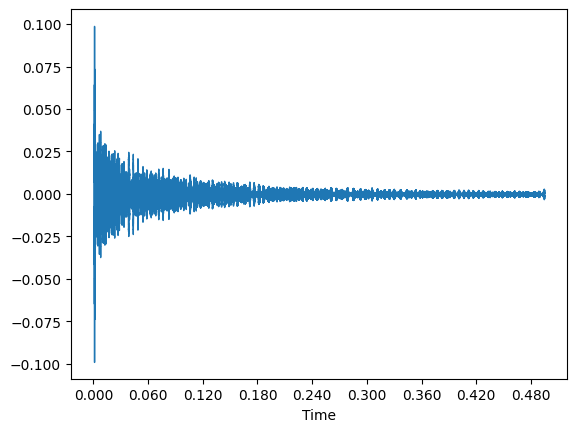

In [25]:
librosa.display.waveshow(f,sr=48000)

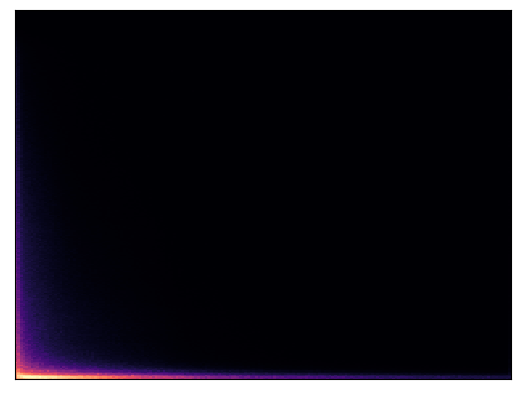

In [26]:
librosa.display.specshow(images[1])

In [27]:
# np.save("/Users/felixm/Downloads/",images)